In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2023-05-16 12:29:58.250217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model

In [4]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.5
    def get_temp(self,):
        return self.temp

In [5]:
# Training parameters
num_iterations = 2000000 # @param {type:"integer"}
n_step_update = 3
initial_collect_steps = 200000  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 2000000  # @param {type:"integer"}
batch_size = 64 # @param {type:"integer"}
learning_rate = 5e-5  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}
gamma = 0.99
temp_schedule = TemperatureSchedule()
boltzmann_temperature = None # temp_schedule.get_temp
fc_layer_params = (512, 20)
epsilon = 0.1
conv_layer_params=[(16,4,4), (32,4,4), (64,2,2)]
target_update_tau = 1
target_update_period = 10000
num_eval_episodes = 200  # @param {type:"integer"}
eval_interval = 50000  # @param {type:"integer"}
single_env =  False
use_sd = True


In [6]:
# Setup environment 
session_name = 'rand_walk_interpol'
env = RLEnv(model_path=session_name, single_env = single_env, use_sd=use_sd)


2023-05-16 12:30:03.547196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:03.550589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:03.550770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/j

2023-05-16 12:30:07.092028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:07.092236: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-16 12:30:07.092335: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-16 12:30:07.092865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:07.093038: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-05-16 12:30:07.635655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:07.635872: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-16 12:30:07.635957: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-16 12:30:07.636154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:07.636328: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-05-16 12:30:10.064213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:10.064422: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-16 12:30:10.064482: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-16 12:30:10.064679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:10.064854: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-05-16 12:30:10.352926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:10.353142: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-16 12:30:10.353232: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-16 12:30:10.353435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 12:30:10.353606: I tensorflow/compiler/xla/stream_executor/

In [7]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-05-16--12:30:10'

In [8]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [9]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

2023-05-16 12:30:11.771665: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-05-16 12:30:11.771788: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-05-16 12:30:16.286505: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 0.8200000049546361
Average error 26.650347068841977


Timer unit: 0.001 s

Total time: 59.8738 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 257

Line #      Hits         Time  Per Hit   % Time  Line Contents
   257                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   258       202          0.1      0.0      0.0  		state_history = self.state_history
   259       202          0.1      0.0      0.0  		city_ob = self.building_grid
   260       202          0.1      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   261       202          0.7      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   262                                           
   263                                           		# Swap columns at this point since
   264       202         20.1      0.1      0.0  		measured_coords = self.get_measured_coords()
   265                                           
   266                                  

In [10]:
# Q-network 
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


In [11]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter =  tf.Variable(0, dtype=tf.int64)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    epsilon_greedy=epsilon,
    q_network=q_net,
    optimizer=optimizer,
    debug_summaries=True,
    n_step_update=n_step_update,
    boltzmann_temperature=boltzmann_temperature,
    gamma=gamma,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2023-05-16 12:31:11.501002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-05-16 12:31:11.975667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors)

In [13]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=100)

print((rand_reward, rand_pred_error))


(9.561298, 36.506314782185974)


In [14]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpnqaio9qm.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpnqaio9qm
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44645


In [15]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)


In [16]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)



In [17]:
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [18]:
best_reward = np.inf
num_eval_episodes = 100
losses = []
collect_rewards = []

In [19]:
for _ in range(1000000000):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(rew)

  step = agent.train_step_counter.numpy()

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2959822) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2959822) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2959822) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2959822) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2959822) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2959822) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, b

step = 1000: loss = 0.0095838513225317,  rew = 0.046699218451976776
step = 2000: loss = 0.009025650098919868,  rew = 0.040117185562849045
step = 3000: loss = 0.0030008903704583645,  rew = 0.055800776928663254
step = 4000: loss = 0.0014467888977378607,  rew = 0.06019531190395355
step = 5000: loss = 0.003315089037641883,  rew = 0.04960937425494194
step = 6000: loss = 0.002224759664386511,  rew = 0.04365234449505806
step = 7000: loss = 0.0013489170232787728,  rew = 0.05162109434604645
step = 8000: loss = 0.0006551534752361476,  rew = 0.03876953199505806
step = 9000: loss = 0.00034116703318431973,  rew = 0.04859375208616257
step = 10000: loss = 0.001226525055244565,  rew = 0.04892577975988388
step = 11000: loss = 0.0010663390858098865,  rew = 0.06421874463558197
step = 12000: loss = 0.0033016554079949856,  rew = 0.06453125178813934
step = 13000: loss = 0.00043860735604539514,  rew = 0.04218749701976776
step = 14000: loss = 0.0007240442209877074,  rew = 0.053398437798023224
step = 15000: lo

KeyboardInterrupt: 

In [ ]:
temp_schedule.temp = 0.1

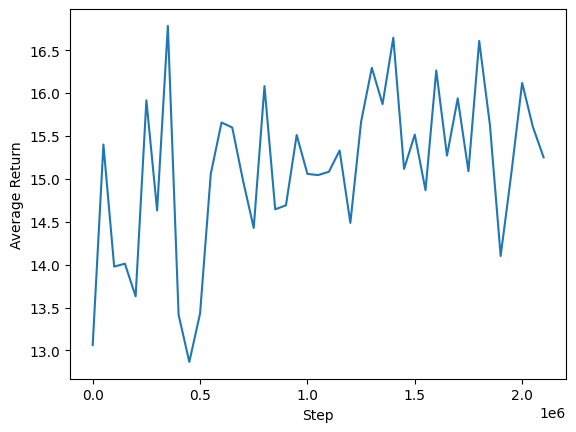

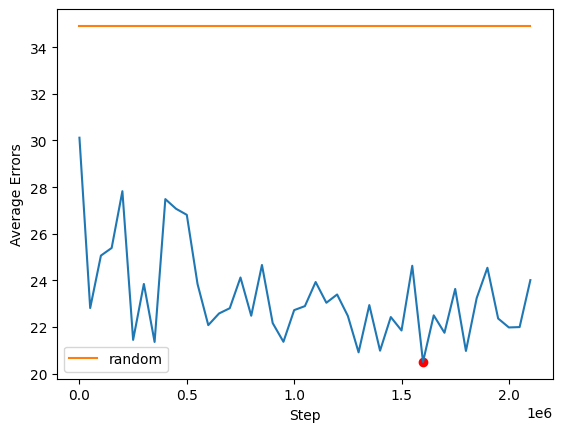

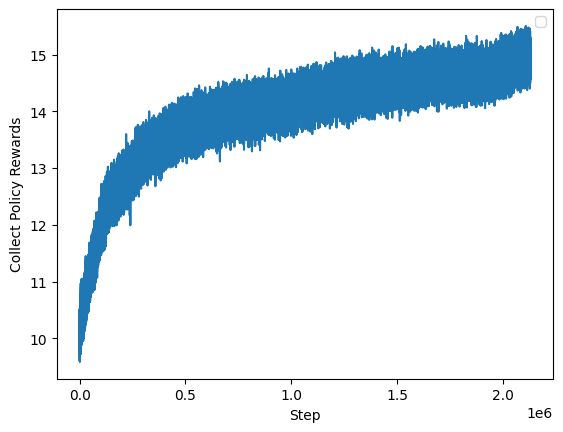

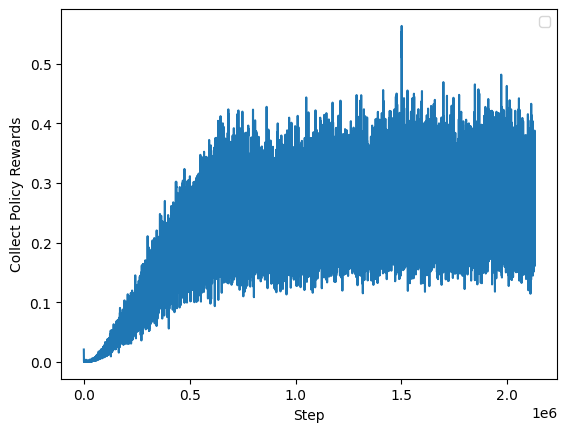

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()
plt.savefig(train_log_dir+'/test_returns.png')

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()
plt.savefig(train_log_dir+'/test_errors.png')

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()
plt.savefig(train_log_dir+'/train_returns.png')


steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Training loss')
plt.xlabel('Step')
plt.legend()
plt.show()
plt.savefig(train_log_dir+'/train_loss.png')

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

KeyboardInterrupt: 

In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

14.793147 25.72983358634253
